In [34]:
%matplotlib widget
from generate_chunks import load_data
from train_models import ModelTrainer
from failure_detection import detect_failures, failure_list_to_interval, print_failures, collate_intervals, extreme_anomaly, simple_lowpass_filter
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

train_chunks, training_chunk_dates, test_chunks, test_chunk_dates = load_data(version=3)


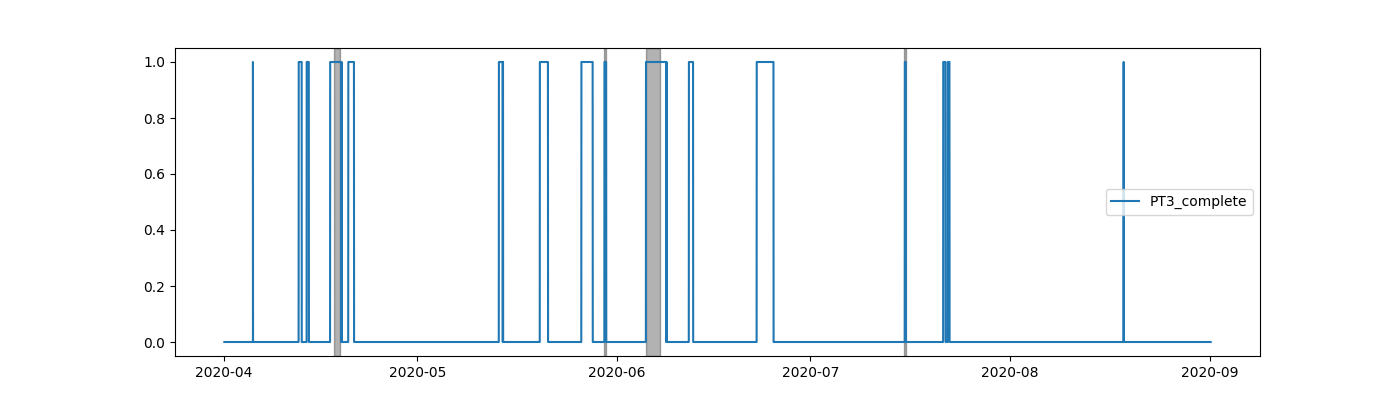

In [37]:
feature_names = ['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature', 'Motor_current', 'COMP']

plt.figure(figsize=(14, 4))

actual_failures = [
    (np.datetime64('2020-04-18T00:00:00'), np.datetime64('2020-04-18T23:59:00')),
    (np.datetime64('2020-05-29T23:30:00'), np.datetime64('2020-05-30T06:00:00')),
    (np.datetime64('2020-06-05T10:00:00'), np.datetime64('2020-06-07T14:30:00')),
    (np.datetime64('2020-07-15T14:30:00'), np.datetime64('2020-07-15T19:00:00')),
]
for (start, end) in actual_failures:
    plt.axvspan(start, end, color='black', alpha=0.3)

model_name = 'PT3_complete'
model = ModelTrainer(f'configs/{model_name}.json').fit()
#val_size = int(0.3 * len(train_chunks))
#train_errors = model.calc_loss(train_chunks[-val_size:], train_chunks[-val_size:], average=False).mean(axis=(1,2))
train_errors = model.calc_loss(train_chunks, train_chunks, average=False).mean(axis=(1,2))
test_errors_raw = model.calc_loss(test_chunks, test_chunks, average=False)
test_errors = test_errors_raw.mean(axis=(1,2))
anom = extreme_anomaly(train_errors)
binary_output = (test_errors > anom).astype(np.int8)
output = simple_lowpass_filter(binary_output, 0.05)
failures = (output > 0.5).astype(np.int8)
plt.plot(test_chunk_dates[:, 1], failures, label=model_name)

plt.legend()
plt.show()

# Investigate error distribution(s)

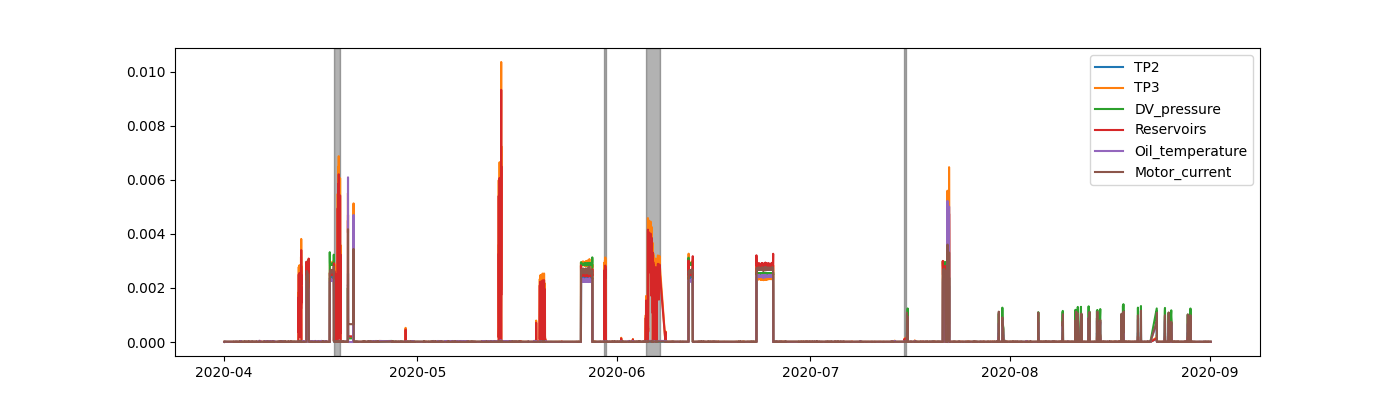

In [38]:
plt.figure(figsize=(14, 4))

for (start, end) in actual_failures:
    plt.axvspan(start, end, color='black', alpha=0.3)

for channel_idx in range(13):
    if channel_idx in [9, 2, 10, 11, 7, 8, 12]:
        continue
    if channel_idx > 8:
        style = '--'
    else:
        style = '-'
    plt.plot(test_chunk_dates[:, 1], test_errors_raw[..., channel_idx].mean(axis=1), label=feature_names[channel_idx], linestyle=style)
plt.legend()
plt.show()


9359595    44.775
9359596    44.825
9359597    44.900
9359598    44.925
9359599    45.025
            ...  
9417518    61.850
9417519    61.975
9417520    62.000
9417521    62.175
9417522    62.250
Name: Oil_temperature, Length: 57928, dtype: float64


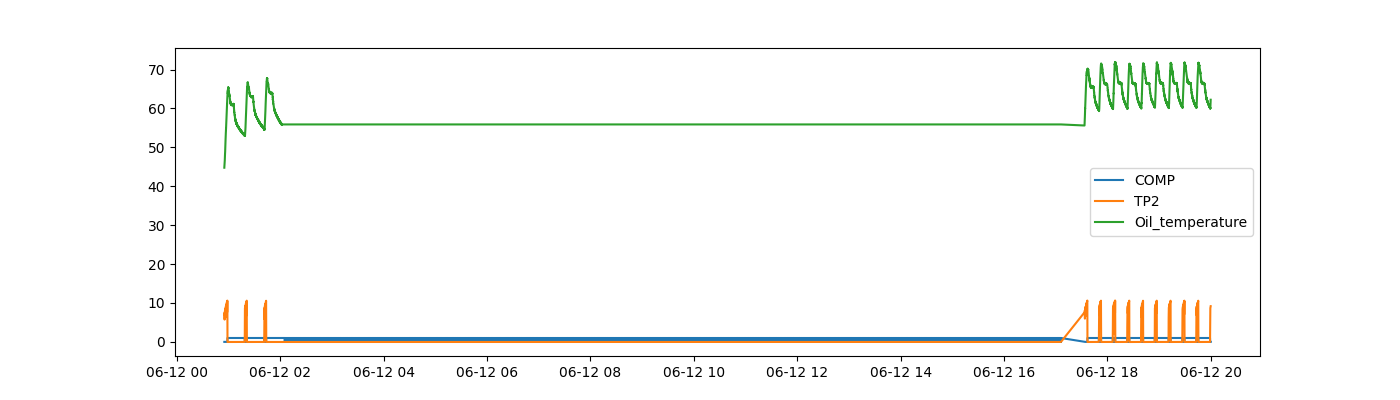

In [39]:
import pandas as pd
df = pd.read_csv(f'MetroPT3.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')
df.reset_index(drop=True, inplace=True)

to_plot = df[(df.timestamp >= np.datetime64('2020-06-12T00:00:00')) & (df.timestamp <= np.datetime64('2020-06-12T20:00:00'))]
plt.figure(figsize=(14, 4))
plt.plot(to_plot.timestamp, to_plot['COMP'], label='COMP')
plt.plot(to_plot.timestamp, to_plot['TP2'], label='TP2')
plt.plot(to_plot.timestamp, to_plot['Oil_temperature'], label='Oil_temperature')
plt.legend()

print(to_plot['Oil_temperature'])

test 2930 2933
test 3763 3905
test 4542 4738
test 12275 12683
test 16288 16425
test 18945 19544
test 25479 25554
test 25666 25710


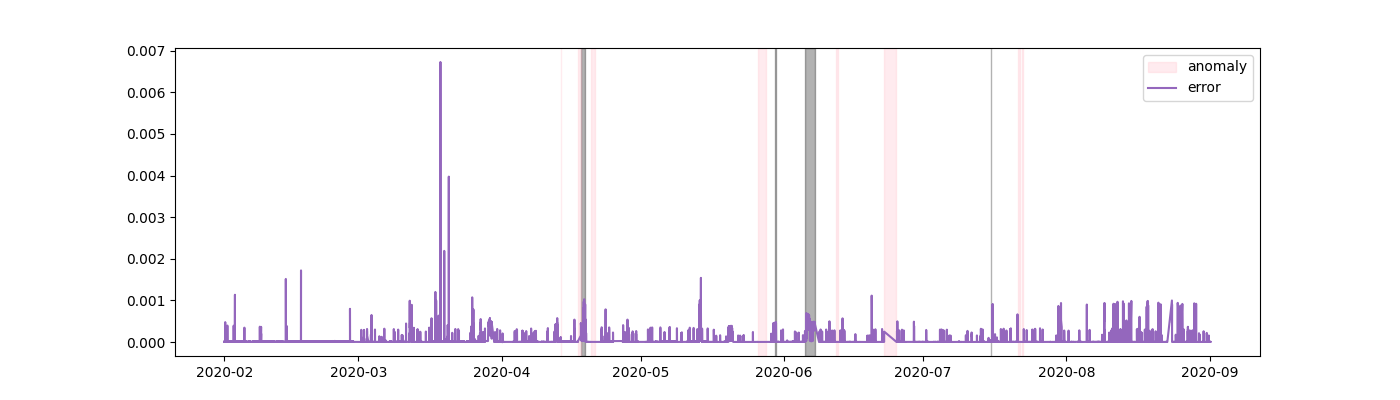

In [44]:
def find_continuous_ranges(arr):
    # Sort the array
    arr = np.sort(arr)
    # Find the gaps in the sorted array
    gaps = np.diff(arr) != 1
    # Get the indices where the gaps are present
    gap_indices = np.where(gaps)[0]
    if len(gap_indices) == 0:
        return []
    # Generate the boundaries of the ranges
    boundaries = np.split(arr, gap_indices + 1)
    # Convert boundaries to list of tuples
    ranges = [(int(sub_arr[0]), int(sub_arr[-1])) for sub_arr in boundaries]
    return ranges

plt.figure(figsize=(14, 4))

for (start, end) in actual_failures:
    plt.axvspan(start, end, color='black', alpha=0.3)

# Train
t = train_chunks[..., [0, 1, 2, 3, 4, 5, 6]]
anomalous = np.all((t.std(axis=1) < 0.01), axis=1)
anomalous_idx = np.where(anomalous)[0]

anomaly_ranges = find_continuous_ranges(anomalous_idx)
for idx, (b, e) in enumerate(anomaly_ranges):
    print('train', b, e)
    plt.axvspan(training_chunk_dates[b, 1], training_chunk_dates[e, 1], color='pink', alpha=0.3, label='anomaly' if idx == 0 else '')

# Test
t = test_chunks[..., [0, 1, 2, 3, 4, 5, 6]]
anomalous = np.all((t.std(axis=1) < 0.01), axis=1)
anomalous_idx = np.where(anomalous)[0]

anomaly_ranges = find_continuous_ranges(anomalous_idx)
for idx, (b, e) in enumerate(anomaly_ranges):
    print('test', b, e)
    plt.axvspan(test_chunk_dates[b, 1], test_chunk_dates[e, 1], color='pink', alpha=0.3, label='anomaly' if idx == 0 else '')

to_delete = []
padding = 10 
for (b, e) in anomaly_ranges:
    to_delete.append(np.arange(b-padding, e+padding+2))
to_delete = np.concatenate(to_delete)
test_chunk_dates_clean = np.delete(test_chunk_dates, to_delete, axis=0)
test_errors_clean = np.delete(test_errors, to_delete, axis=0)

plt.plot(training_chunk_dates[:, 1], train_errors, color='C4', label='error')
plt.plot(test_chunk_dates_clean[:, 1], test_errors_clean, color='C4')
plt.legend()